In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg
import scipy
import mpl_toolkits.mplot3d as a3
import matplotlib.colors as colors

%matplotlib inline
%matplotlib nbagg

a = 6378137.
b = 6356752.
f = (a - b) / a
e2 = 2 * f - f * f
e = np.sqrt(e2)
s = 10000
ta = np.sqrt((s / 6) / (np.sqrt(3) / 4)) # side of triangle

def proj_to_ellipse(p):
    #f_id = get_icos_face(p)
    #p = p / np.linalg.norm(p) * a
    #O = sum(icos[v] for v in faces[f_id]) / 3.0
    #A = ellipse_value(O)
    #B = 2 * np.dot(O, p)
    #C = ellipse_value(p)
    #alpha = ((-B + np.sqrt(B ** 2 - 4 * A * C)) / (2 * A))
    #print(ellipse_value(p + alpha * O))
    #return p + alpha * O
    return p / np.sqrt(ellipse_value(p))

# (u, v) = parametric (lat, long)
# geodesic lat, long are given by
def geo_lat(u):
    return np.arctan(np.tan(u) / np.sqrt(1 - e2))

def param_lat(u):
    return np.arctan(np.tan(u) * np.sqrt(1 - e2))

def param_to_r3(u, v, aa=a, bb=a, cc=b):
    return np.array([aa * np.cos(u) * np.cos(v), bb * np.cos(u) * np.sin(v), cc * np.sin(u)])

def r3_to_param(p):
    p = proj_to_ellipse(p)
    lat = np.arcsin(p[2] / b)
    long = np.arctan2(p[1] / np.cos(lat), p[0] / np.cos(lat))
    return np.array([lat, long])

def proj(v, axis):
    return np.dot(v, axis) / np.dot(axis, axis) * axis

def proj_on_plane(v, norm):
    return v - proj(v, norm)

def rotation_matrix(axis, theta):
    return scipy.linalg.expm(np.cross(np.eye(3), axis / np.linalg.norm(axis) * theta))

def ellipse_value(p):
    return (p[0] ** 2 + p[1] ** 2) / (a ** 2) + (p[2] / b) ** 2

In [2]:
def go_up(p):
    l, r = 0.0, 0.0001
    lat, long = r3_to_param(p)
    for _ in range(100):
        m = (l + r) / 2.
        pt = param_to_r3(lat + m, long)
        if np.linalg.norm(pt - p1) > ta:
            r = m
        else:
            l = m
    res = param_to_r3(lat + l, long)
    assert(np.abs(np.linalg.norm(res - p) - ta) < 1e-5)
    return res

def triangle(p1, p2):
    m = (p1 + p2) / 2.0
    v = proj_on_plane(-m, p2 - p1)
    v = v / np.linalg.norm(v) * (ta * np.sqrt(3) / 2)
    assert(ellipse_value(m + v) < 1.)
    assert(ellipse_value(m - v) > 1.)
    
    l, r = 0, np.pi
    for _ in range(60):
        mid = (l + r) / 2.
        cur = m + np.dot(rotation_matrix(p2 - p1, mid), v)
        if ellipse_value(cur) < 1.:
            l = mid
        else:
            r = mid
    return (m + np.dot(rotation_matrix(p2 - p1, l), v),
            m + np.dot(rotation_matrix(p2 - p1, -l), v))

In [3]:
# form icos
icos = list()
icos.append(np.array([0., 0., 1.]))
icos.append(np.array([0., 0., -1.]))
lat, long = np.arctan(0.5), 0.
for _ in range(10):
    icos.append(param_to_r3(lat, long, 1., 1., 1.))
    lat *= -1
    long += np.pi / 5

faces = list()
for i in range(10):
    faces.append((2 + i, 2 + (i + 1) % 10, 2 + (i + 2) % 10))
for i in range(10):
    faces.append((i % 2, 2 + i, 2 + (i + 2) % 10))    
    
adj_faces = [[0 for _ in range(len(icos))] for _ in range(len(icos))]
for (f_id, f) in enumerate(faces):
    for i in range(3):
        adj_faces[f[i]][f[(i + 1) % 3]] ^= f_id
        adj_faces[f[(i + 1) % 3]][f[i]] ^= f_id
            
assert(len(icos) == 12)
assert(len(faces) == 20)

In [4]:
import itertools

# form pentakis dodecahedron
phi = (1 + np.sqrt(5)) / 2.0
side = np.sqrt(5) - 1
h = 1.15
#h = 1.5

icos = list()
for x, y, z in itertools.product([-1, 1], repeat=3):
    icos.append(np.array([x, y, z]))
for s1, s2 in itertools.product([-1, 1], repeat=2):
    icos.append(np.array([0, s1 / phi, s2 * phi]))
    icos.append(np.array([s1 / phi, s2 * phi, 0]))
    icos.append(np.array([s2 * phi, 0, s1 / phi]))

    
faces = list()
for s1, s2 in itertools.product([-1, 1], repeat=2):
    for perm in [(0, 1), (1, 2), (2, 0)]:
        fc = list()
        for i, v in enumerate(icos):
            if np.abs(phi * v[perm[0]] + s1 * v[perm[1]] - s2 * (phi ** 2)) < 1e-5:
                fc.append(i)
        assert(len(fc) == 5)
        for i in range(4):
            for j in range(i + 1, 5):
                if np.abs(np.linalg.norm(icos[fc[i]] - icos[fc[j]]) - side) < 1e-5:
                    fc[i + 1], fc[j] = fc[j], fc[i + 1]
                    break
        fc.append(fc[0])
        for i in range(5):
            assert(np.abs(np.linalg.norm(icos[fc[i]] - icos[fc[i + 1]]) - side) < 1e-5)
        faces.append(tuple(fc[:5]))
dod_faces = faces

<IPython.core.display.Javascript object>


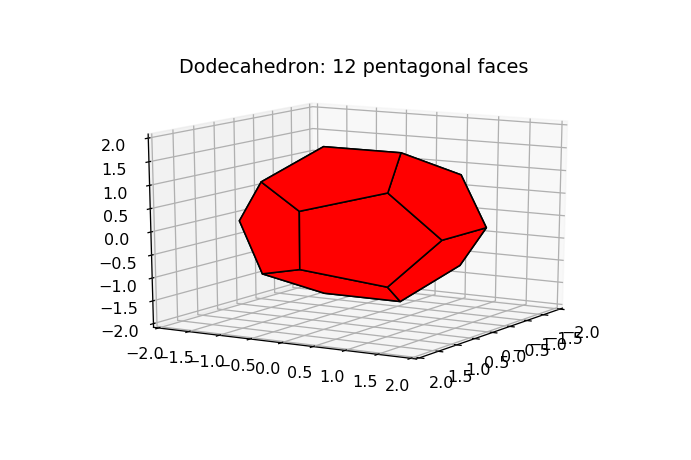

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
ax.view_init(14, 31)

for face_id in range(len(faces)):
    fc = list(faces[face_id])
    fc.append(fc[0])
    fc = [icos[v] for v in fc]
    
    tri = a3.art3d.Poly3DCollection([fc])
    tri.set_color(colors.rgb2hex((1, 0, 0)))
    tri.set_edgecolor('k')
    ax.add_collection3d(tri)
    
plt.title('Dodecahedron: 12 pentagonal faces')
plt.show()

In [6]:
new_v = list()
faces = list()
cnt = len(icos)
for s1, s2 in itertools.product([-1, 1], repeat=2):
    for perm in [(0, 1), (1, 2), (2, 0)]:
        fc = list()
        for i, v in enumerate(icos):
            if np.abs(phi * v[perm[0]] + s1 * v[perm[1]] - s2 * (phi ** 2)) < 1e-5:
                fc.append(i)
        assert(len(fc) == 5)
        for i in range(4):
            for j in range(i + 1, 5):
                if np.abs(np.linalg.norm(icos[fc[i]] - icos[fc[j]]) - side) < 1e-5:
                    fc[i + 1], fc[j] = fc[j], fc[i + 1]
                    break
        #print(fc)
        fc.append(fc[0])
        for i in range(5):
            assert(np.abs(np.linalg.norm(icos[fc[i]] - icos[fc[i + 1]]) - side) < 1e-5)
            
        O = sum(icos[v] for v in fc) / len(fc) * h
        new_v.append(O)
        #print(np.linalg.norm(icos[fc[0]] - O))
        
        for i in range(5):
            faces.append((cnt, fc[i], fc[i + 1]))
        cnt += 1
        
icos += new_v
assert(len(faces) == 60)
assert(len(icos) == 32)

adj_faces = [[0 for _ in range(len(icos))] for _ in range(len(icos))]
for (f_id, f) in enumerate(faces):
    for i in range(3):
        adj_faces[f[i]][f[(i + 1) % 3]] ^= f_id
        adj_faces[f[(i + 1) % 3]][f[i]] ^= f_id

<IPython.core.display.Javascript object>


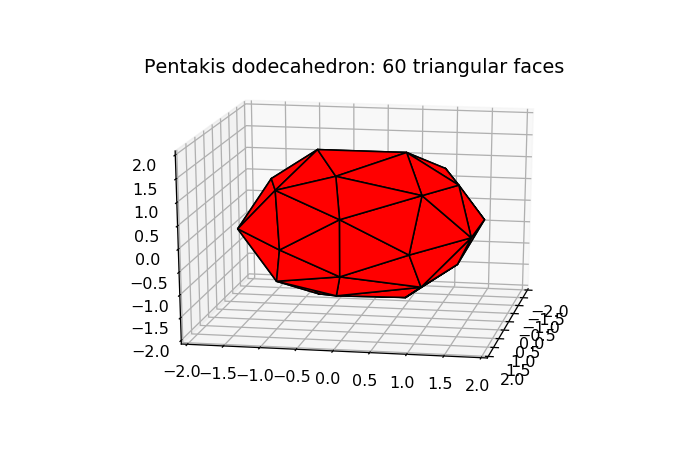

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
ax.set_zlim(-2, 2)
ax.view_init(14, 31)

for face_id in range(len(faces)):
    fc = list(faces[face_id])
    fc.append(fc[0])
    fc = [icos[v] for v in fc]
    
    tri = a3.art3d.Poly3DCollection([fc])
    tri.set_color(colors.rgb2hex((1, 0, 0)))
    tri.set_edgecolors('k')
    ax.add_collection3d(tri)
    
plt.title('Pentakis dodecahedron: 60 triangular faces')
plt.show()

In [8]:
S = 2 * np.pi * a * a * (1 + (1 - e2) / e * np.arctanh(e)) / len(faces)
S = 4 * np.pi * a * a / len(faces)
print('Square of Earth =', S * 20, 'm^2')
N = int(np.sqrt(6 * S / 10000))
if N % 3 != 0:
    N += 3 - N % 3
n_triang = N * N
n_hex = n_triang / 6
print('%d faces, N = %d, %d triangles, %d hexes, S_hex = %f m^2' % (len(faces), N, n_triang, n_hex, S / n_hex))

Square of Earth = 170402631131937.0 m^2
60 faces, N = 71499, 5112107001 triangles, 852017833 hexes, S_hex = 9999.945097 m^2


In [9]:
def get_icos_face(p):
    for f_id, (i, j, k) in enumerate(faces):
        M = np.array([icos[i], icos[j], icos[k]]).T
        coeff = np.linalg.inv(M).dot(p)
        if (coeff >= -1e-10).all():
            return f_id
        
def get_face_projection(a, parts=10):
    pts = list()
    for i in range(len(a)):
        pts += [a[i] * (1 - t) + a[(i + 1) % len(a)] * t for t in np.linspace(0., 1., parts)]
    return [proj_to_ellipse(p) for p in pts]

def get_projection_square(a, b, c, parts=10):
    face = get_face_projection([a, b, c], parts=parts)
    O, S = proj_to_ellipse(sum(face) / len(face)), 0.0
    for i in range(-1, len(face) - 1):
        S += np.linalg.norm(np.cross(face[i] - O, face[i + 1] - O)) / 2.0
    return S

def point_by_bari(face_id, b1, b2, b3):
    assert(b1 + b2 + b3 == N)
    a1, a2, a3 = icos[faces[face_id][0]], icos[faces[face_id][1]], icos[faces[face_id][2]]
    return (a1 * b1 + a2 * b2 + a3 * b3) / N

def bari_by_point(p):
    for f_id, (i, j, k) in enumerate(faces):
        M = np.array([icos[i], icos[j], icos[k]]).T
        coeff = np.linalg.inv(M).dot(p)
        if not (coeff > 0).all():
            continue
        coeff = coeff / sum(coeff) * N
        b1 = int(coeff[0] + 1)
        b3 = int(coeff[2])
        b2 = N - b1 - b3
        return (f_id, b1, b2, b3, 1 if coeff[1] > b2 else 0)
    
def is_hex_center(b1, b2, b3):
    return b1 % 3 == b2 % 3 == b3 % 3

def neighbors(b1, b2, b3):
    for dx in [[1, 0, -1], [1, -1, 0], [0, -1, 1], [-1, 0, 1], [-1, 1, 0], [0, 1, -1]]:
        yield b1 + dx[0], b2 + dx[1], b3 + dx[2]
        
def get_vertex_hex(v_id):
    for i in range(len(faces)):
        if v_id not in faces[i]:
            continue
        bari = [0, 0, 0]
        bari[faces[i].index(v_id)] = N
        return (i,) + tuple(bari)
    assert(False)
    
def unify_hex_id(hex_id):
    # unify ids for hexes on the border of triangles (and out of triangles)
    f_id, bari = hex_id[0], hex_id[1:]
    for pos in range(3):
        if bari[pos] == 0:
            if len(set(bari)) == 2:
                # it's a vertex
                v_pos = min(i for i in range(3) if bari[i] != 0)
                return get_vertex_hex(faces[f_id][v_pos])

            min_face_id, new_bari = f_id, bari
            v1, v2 = faces[f_id][(pos + 1) % 3], faces[f_id][(pos + 2) % 3]
            
            new_face_id = adj_faces[v1][v2] ^ f_id
            if new_face_id < min_face_id:
                new_bari = [0, 0, 0]
                new_bari[faces[new_face_id].index(v1)] = bari[(pos + 1) % 3]
                new_bari[faces[new_face_id].index(v2)] = bari[(pos + 2) % 3]
                min_face_id = new_face_id # WAT
            return (min_face_id,) + new_bari
        if bari[pos] < 0:
            v1, v2 = faces[f_id][(pos + 1) % 3], faces[f_id][(pos + 2) % 3]
            new_face_id = adj_faces[v1][v2] ^ f_id
            new_bari = [0, 0, 0]
            i1, i2 = faces[new_face_id].index(v1), faces[new_face_id].index(v2)
            i3 = 3 - i1 - i2
            new_bari[i1] = bari[(pos + 1) % 3] + bari[pos]
            new_bari[i2] = bari[(pos + 2) % 3] + bari[pos]
            new_bari[i3] = -bari[pos]
            assert(sum(new_bari) == N)
            # recurse, maybe not all is yet good
            return unify_hex_id((new_face_id,) + tuple(new_bari))
    return hex_id

        
def get_hex_id(p):
    f_id, b1, b2, b3, up = bari_by_point(p)
    baris = [(b1, b2, b3), (b1 - 1, b2, b3 + 1)]
    if up:
        baris.append((b1 - 1, b2 + 1, b3))
    else:
        baris.append((b1, b2 - 1, b3 + 1))
        
    for v in baris:
        if is_hex_center(*v):
            return unify_hex_id((f_id,) + v)
    assert(False)
    
    #hex_id = None
    #if is_hex_center(b1, b2, b3):
    #    hex_id = (f_id, b1, b2, b3)
    #if b1 > 0 and is_hex_center(b1 - 1, b2 + 1, b3) and up:
    #    hex_id = (f_id, b1 - 1, b2 + 1, b3)
    #if b1 > 0 and is_hex_center(b1 - 1, b2, b3 + 1):
    #    hex_id = (f_id, b1 - 1, b2, b3 + 1)
    #if b2 > 0 and is_hex_center(b1, b2 - 1, b3 + 1) and not up:
    #    hex_id = (f_id, b1, b2 - 1, b3 + 1)
    #assert(hex_id is not None)
    #return unify_hex_id(hex_id)
    
def hex_id_by_geo_lat_lon(lat, lon):
    return get_hex_id(param_to_r3(param_lat(lat), lon))

def hex_id_by_param_lat_lon(lat, lon):
    return get_hex_id(param_to_r3(lat, lon))

def hex_neighbors(hex_id):
    f_id, bari = hex_id[0], hex_id[1:]
    result = list()
    for dx in [[-1, 2, -1], [-2, 1, 1], [-1, -1, 2], [1, -2, 1], [2, -1, -1], [1, 1, -2]]:
        new_bari = list(bari)
        for i in range(3):
            new_bari[i] += dx[i]
        result.append(unify_hex_id((f_id,) + tuple(new_bari)))
    return result

print(hex_neighbors((1, N, 0, 0)))
#print(get_projection_square(icos[faces[1][0]], icos[faces[1][1]], icos[faces[0][2]]))

[(0, 71497, 1, 1), (1, 71497, 1, 1), (2, 71497, 1, 1), (3, 71497, 1, 1), (4, 71497, 1, 1), (4, 71497, 1, 1)]


<IPython.core.display.Javascript object>


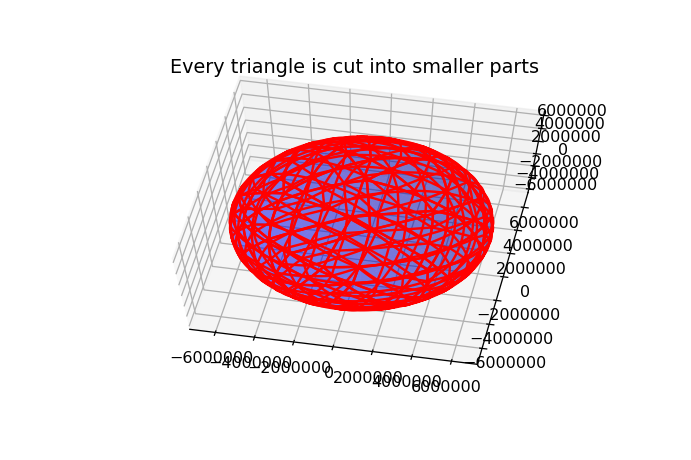

In [10]:
N = 3
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Make data
u = np.linspace(-np.pi / 2, np.pi / 2, 30)
v = np.linspace(-np.pi, np.pi, 30)
x = a * np.outer(np.cos(u), np.cos(v))
y = a * np.outer(np.cos(u), np.sin(v))
z = b * np.outer(np.sin(u), np.ones(len(v)))

# Plot the surface
ax.plot_surface(x, y, z, color='b', alpha=0.3)
for face_id in range(len(faces)):
    #ax.plot(*zip(icos[i], icos[j], icos[k], icos[i]), color='r')
    
    # we draw only traingles of the form (a, b, c), (a - 1, b + 1, c), (a - 1, b, c + 1)
    for b1 in range(1, N + 1):
        for b2 in range(N + 1 - b1):
            a1 = point_by_bari(face_id, b1, b2, N - b1 - b2)
            a2 = point_by_bari(face_id, b1 - 1, b2 + 1, N - b1 - b2)
            a3 = point_by_bari(face_id, b1 - 1, b2, N + 1 - b1 - b2)
            pts = get_face_projection([a1, a2, a3])
            ax.plot(*zip(*pts), color='r')

plt.title('Every triangle is cut into smaller parts')
plt.show()

In [11]:
N = 3
pu, pv = 1.056357, 0.993328
p = param_to_r3(pu, pv)
face_id, b1, b2, b3, up = bari_by_point(p)
assert(b1 + b2 + b3 == N)
print(b1, b2, b3, up)

1 2 0 0


<IPython.core.display.Javascript object>


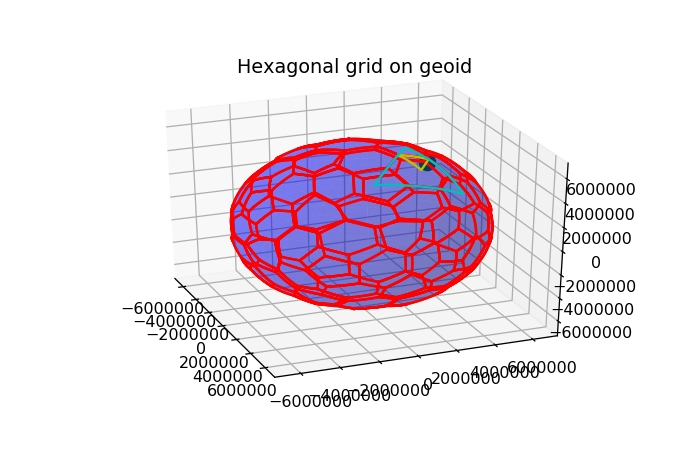

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Make data
u = np.linspace(-np.pi / 2, np.pi / 2, 30)
v = np.linspace(-np.pi, np.pi, 30)
x = a * np.outer(np.cos(u), np.cos(v))
y = a * np.outer(np.cos(u), np.sin(v))
z = b * np.outer(np.sin(u), np.ones(len(v)))

# Plot the surface
ax.plot_surface(x, y, z, color='b', zorder=0, alpha=0.3)

for f_id in range(len(faces)):
    for bb1 in range(N + 1):
        for bb2 in range(N + 1 - bb1):
            bb3 = N - bb1 - bb2
            if not is_hex_center(bb1, bb2, bb3):
                continue
            
            pts = [(nb1, nb2, nb3) for (nb1, nb2, nb3) in neighbors(bb1, bb2, bb3) 
                   if nb1 >= 0 and nb2 >= 0 and nb3 >= 0]
            pts = [point_by_bari(f_id, nb1, nb2, nb3) for (nb1, nb2, nb3) in pts]
            pts = get_face_projection(pts)
            ax.plot(*zip(*pts), color='r')

a1 = point_by_bari(face_id, b1, b2, b3)
a2 = point_by_bari(face_id, b1 - 1, b2, b3 + 1)
a3 = point_by_bari(face_id, b1 - up, b2 + (2 * up - 1), b3 + 1 - up)
pts = get_face_projection([a1, a2, a3])
ax.plot(*zip(*pts), color='y')
ax.scatter(p[0], p[1], p[2], s=100, color='g')

pts = get_face_projection([icos[faces[face_id][0]], icos[faces[face_id][1]], icos[faces[face_id][2]]])
ax.plot(*zip(*pts), color='c')
plt.title('Hexagonal grid on geoid')
plt.show()

triangle id =  58 25 6 5 1
hex id =  58 24 6 6


<IPython.core.display.Javascript object>


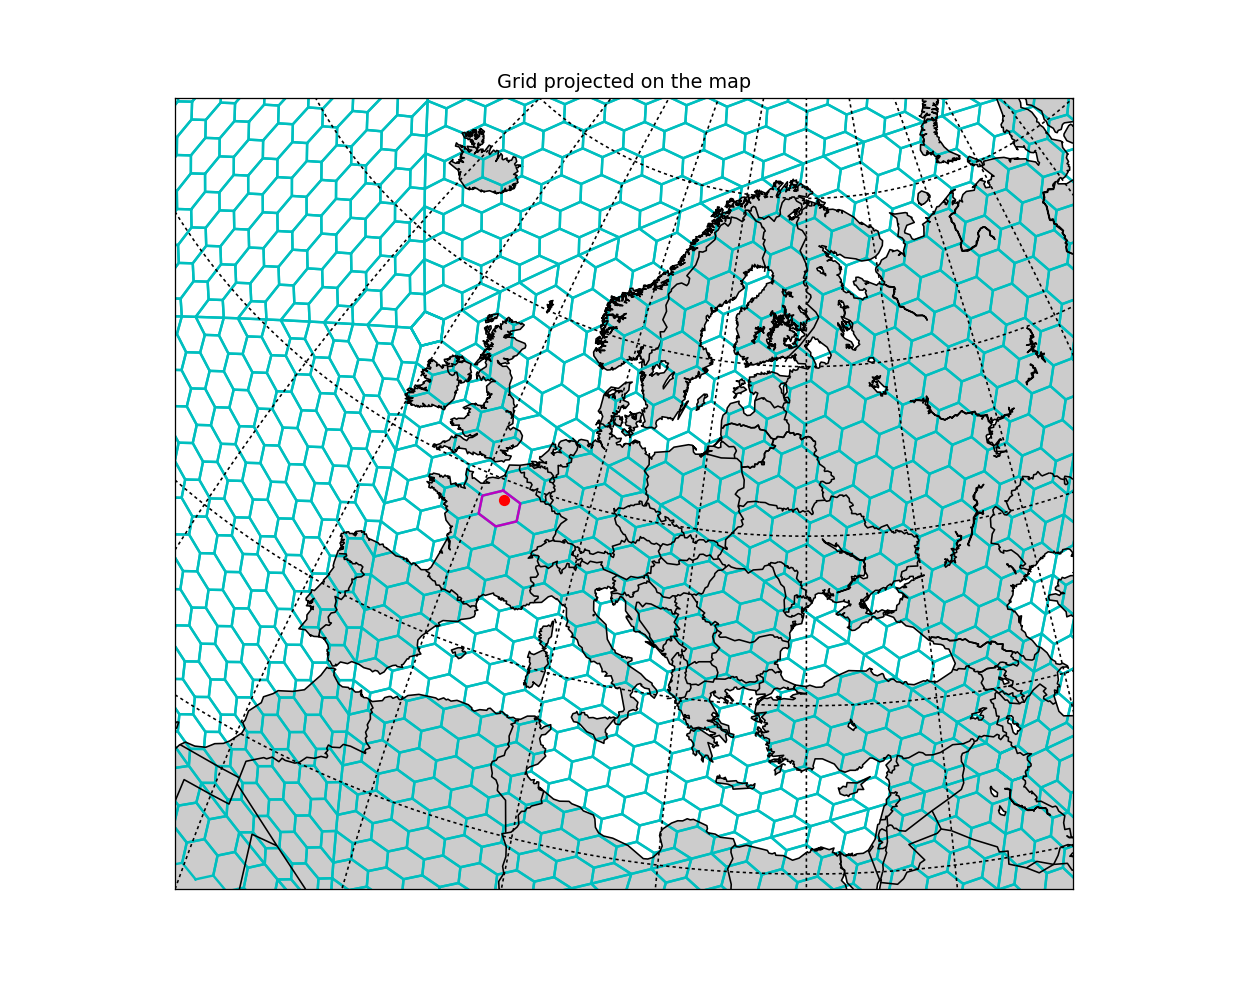

/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:1767: MatplotlibDeprecationWarning: The get_axis_bgcolor function was deprecated in version 2.0. Use get_facecolor instead.
  axisbgc = ax.get_axis_bgcolor()
/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_cha

In [13]:
from mpl_toolkits.basemap import Basemap

N = 36

lon, lat = 2.294694, 48.858093
p = param_to_r3(param_lat(lat / 180 * np.pi), lon / 180 * np.pi)
face_id, b1, b2, b3, up = bari_by_point(p)
assert(b1 + b2 + b3 == N)
print('triangle id = ', face_id, b1, b2, b3, up)
face_hex, h1, h2, h3 = get_hex_id(p)
print('hex id = ', face_hex, h1, h2, h3)
assert(face_id == face_hex)

fig = plt.figure()
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
m = Basemap(
    llcrnrlon=-10.,llcrnrlat=20.,urcrnrlon=80.,urcrnrlat=70.,
    rsphere=(a, b), resolution='l',projection='laea',
    lat_0=48, lon_0=30)
m.drawcoastlines()
m.fillcontinents(zorder=0)
m.drawcountries(linewidth=1.0)
m.drawparallels(np.arange(30, 80, 10))
m.drawmeridians(np.arange(-20, 80, 10))
m.scatter(lon, lat, marker='o', color='r', latlon=True)

for f_id in range(len(faces)):
    # we draw only traingles of the form (a, b, c), (a - 1, b + 1, c), (a - 1, b, c + 1)
    for bb1 in range(N + 1):
        for bb2 in range(N + 1 - bb1):
            bb3 = N - bb1 - bb2
            if not is_hex_center(bb1, bb2, bb3):
                continue
            
            pts = [(nb1, nb2, nb3) for (nb1, nb2, nb3) in neighbors(bb1, bb2, bb3) 
                   if nb1 >= 0 and nb2 >= 0 and nb3 >= 0]
            pts = [point_by_bari(f_id, nb1, nb2, nb3) for (nb1, nb2, nb3) in pts]
            pts = [r3_to_param(proj_to_ellipse(pt)) for pt in pts] 
            pts.append(pts[0])
            pts = [(lon * 180 / np.pi, geo_lat(lat) * 180 / np.pi) for (lat, lon) in pts]
            x, y = list(zip(*pts))
            x, y = np.array(x), np.array(y)
            if ((x >= -60) & (x <= 90) & (y >= 20) & (y <= 90)).all():
                color = 'm' if (f_id, bb1, bb2, bb3) == (face_id, h1, h2, h3) else 'c'
                zorder= 2 if (bb1, bb2, bb3) == (h1, h2, h3) else 1
                m.plot(x, y, color=color, zorder=zorder, latlon=True)
                
                
#a1 = point_by_bari(face_id, b1, b2, b3)
#a2 = point_by_bari(face_id, b1 - 1, b2, b3 + 1)
#a3 = point_by_bari(face_id, b1 - up, b2 + (2 * up - 1), b3 + 1 - up)
#pts = [r3_to_param(proj_to_ellipse(pt)) for pt in [a1, a2, a3, a1]]
pts = [(lon * 180 / np.pi, geo_lat(lat) * 180 / np.pi) for (lat, lon) in pts]
x, y = list(zip(*pts))
x, y = np.array(x), np.array(y)
m.plot(x, y, color='y', latlon=True)
plt.title('Grid projected on the map')
plt.show()

In [14]:
N = int(np.sqrt(6 * S / 10000))
if N % 3 != 0:
    N += 3 - N % 3

a1 = point_by_bari(10, N, 0, 0)
a2 = point_by_bari(10, N - 1, 1, 0)
a3 = point_by_bari(10, N - 1, 0, 1)
S1 = get_projection_square(a1, a2, a3, parts=1)
print(S1 * 6)

a1 = point_by_bari(10, N // 3, N // 3, N - 2 * (N // 3))
a2 = point_by_bari(10, N // 3 - 1, N // 3 + 1, N - 2 * (N // 3))
a3 = point_by_bari(10, N // 3 - 1, N // 3, N - 2 * (N // 3) + 1)
S2 = get_projection_square(a1, a2, a3, parts=1)
print(S2 * 6)
print(S2 / S1)

for _ in range(10):
    b1 = np.random.randint(1, N + 1)
    b2 = np.random.randint(N + 1 - b1)
    b3 = N - b1 - b2
    a1 = point_by_bari(10, b1, b2, b3)
    a2 = point_by_bari(10, b1 - 1, b2 + 1, b3)
    a3 = point_by_bari(10, b1 - 1, b2, b3 + 1)
    S2 = get_projection_square(a1, a2, a3, parts=1)
    print(S2 / S1, S2 / S1 - 1)

8113.26659896
8456.93512332
1.04235883539
1.0057699628 0.00576996280184
1.00954236687 0.00954236687337
0.977353611134 -0.0226463888662
1.03156045743 0.0315604574342
1.00198247065 0.00198247065011
1.01450721155 0.014507211551
1.04168272598 0.041682725981
0.930505274238 -0.0694947257615
1.05519292196 0.0551929219596
1.00171419244 0.00171419244124


In [15]:
with open('obj_with_squares_300x300_objects.csv') as fi:
    with open('obj_with_squares_300x300_objects_2.csv', 'w') as fo:
        for line in fi:
            if line.count('|') > 34: # there are some bad lines
                continue
            fo.write(line)

In [16]:
import pandas as pd
objs = pd.read_csv('obj_with_squares_300x300_objects_2.csv', engine='python', sep='<\|<')
objs.head()

,Adress_F,adress_w,date_first_product,office,first_product,sex,Age,prod,is_active,commissions_sum,...,quality,lon2,lat2,lon3,lat3,square_id,c1,c2,c3,c4
0,"620042,СВЕРДЛОВСКАЯ, ,ЕКАТЕРИНБУРГ, ,БАКИНСКИХ...",NaN,10/11/2014,9539,Текущий счет,NaN,33,"ПБУ,",0,0.0,...,exact,60.607176|56.913525,60.607176,56.913525,19952.0,56.914065,60.607156,56.913167,60.608799,NaN
1,"620144,СВЕРДЛОВСКАЯ, ,ЕКАТЕРИНБУРГ, ,ЩОРСА,130...",NaN,21/10/2016,9539,Текущий счет,NaN,39,"ПБУ,",1,NaN,...,street,60.613905|56.809014,60.613905,56.809014,54756.0,56.809861,60.613725,56.808963,60.615368,NaN
2,"620144,СВЕРДЛОВСКАЯ, ,ЕКАТЕРИНБУРГ, ,8 МАРТА,8...",NaN,04/12/2012,9539,Текущий счет,NaN,28,"ПБУ,",0,100.0,...,exact,60.603844|56.81906,60.603844,56.819060,51449.0,56.819742,60.602229,56.818844,60.603872,NaN
3,"620016,СВЕРДЛОВСКАЯ, ,ЕКАТЕРИНБУРГ, ,АМУНДСЕНА...",NaN,30/09/2014,9539,Текущий счет,NaN,28,"ПБУ,",0,0.0,...,near,60.574298|56.793302,60.574298,56.793302,60131.0,56.793691,60.572669,56.792793,60.574311,NaN
4,"620000,СВЕРДЛОВСКАЯ, ,ЕКАТЕРИНБУРГ, ,РЫБАКОВ,6...",NaN,10/11/2014,9539,Текущий счет,NaN,24,"ПБУ,",0,0.0,...,number,60.722295|56.875723,60.722295,56.875723,32622.0,56.876336,60.722114,56.875438,60.723757,NaN


In [17]:
coords = objs[['lat2', 'lon3']]
coords = coords[~coords['lat2'].str.contains('\|')].astype(float)
coords.rename(index=str, columns={'lat2': 'lon3', 'lon3': 'lat2'}, inplace=True)
# clean some dirt and turn into radians
coords['lat2'] = coords['lat2'] * (np.pi / 180)
coords['lon3'] = coords['lon3'] * (np.pi / 180)
coords['lat_param'] = coords['lat2'].apply(param_lat)
coords.head()

,lon3,lat2,lat_param
0,1.057795,0.993328,0.991791
1,1.057912,0.991504,0.989965
2,1.057737,0.991680,0.990140
3,1.057221,0.991230,0.989690
4,1.059804,0.992669,0.991131


In [18]:
%%time
N = int(np.sqrt(6 * S / 10000))
if N % 3 != 0:
    N += 3 - N % 3
coords['hex_id'] = [hex_id_by_param_lat_lon(lat, lon) for (lat, lon) in zip(coords['lat_param'], coords['lon3'])]

CPU times: user 44.5 s, sys: 370 ms, total: 44.9 s
Wall time: 44.6 s


In [19]:
hexes = pd.DataFrame(coords.copy()['hex_id'].value_counts(), columns=['hex_id'])
hexes.reset_index(inplace=True)
hexes.rename(index=str, columns={"hex_id": "count", "index": "hex_id"}, inplace=True)
hexes.head()

,hex_id,count
0,"(57, 581, 40226, 30692)",255
1,"(57, 574, 40318, 30607)",193
2,"(57, 652, 40174, 30673)",170
3,"(57, 708, 40221, 30570)",169
4,"(57, 572, 40313, 30614)",159


In [20]:
def hex_center(hex_id):
    f_id, b1, b2, b3 = hex_id
    assert(is_hex_center(b1, b2, b3))
    p = point_by_bari(f_id, b1, b2, b3)
    lat, lon = r3_to_param(p)
    lat, lon = geo_lat(lat) * 180 / np.pi, lon * 180 / np.pi
    return lat, lon

def hex_corners(hex_id):
    f_id, b1, b2, b3 = hex_id
    assert(is_hex_center(b1, b2, b3))
    if b1 == 0 or b2 == 0 or b3 == 0:
        raise ValueError('Not a hex, but a pentagon')
        
    corners = list()
    for neigh in neighbors(b1, b2, b3):
        p = point_by_bari(f_id, *neigh)
        lat, lon = r3_to_param(p)
        lat, lon = geo_lat(lat) * 180 / np.pi, lon * 180 / np.pi
        corners.append((lat, lon))
    return corners

In [21]:
hexes['hex_center'] = hexes['hex_id'].apply(hex_center)
hexes['corners'] = hexes['hex_id'].apply(hex_corners)
for i in range(7):
    f = lambda x: x[i % 6]
    hexes['corner' + str(i)] = hexes['corners'].apply(f)
hexes.head()

,hex_id,count,hex_center,corners,corner0,corner1,corner2,corner3,corner4,corner5,corner6
0,"(57, 581, 40226, 30692)",255,"(56.7919339366, 60.6263020234)","[(56.7924710582, 60.6258657659), (56.791963189...","(56.7924710582, 60.6258657659)","(56.7919631897, 60.6252496958)","(56.7914260715, 60.6256859582)","(56.7913968167, 60.6267382658)","(56.7919046749, 60.627354342)","(56.7924417981, 60.6269181045)","(56.7924710582, 60.6258657659)"
1,"(57, 574, 40318, 30607)",193,"(56.8348799816, 60.6860984757)","[(56.8354173947, 60.6856627815), (56.834909885...","(56.8354173947, 60.6856627815)","(56.8349098856, 60.6850452772)","(56.8343724757, 60.6854809765)","(56.83434257, 60.6865341549)","(56.8348500689, 60.6871516651)","(56.8353874837, 60.6867159909)","(56.8354173947, 60.6856627815)"
2,"(57, 652, 40174, 30673)",170,"(56.8036474959, 60.5632578993)","[(56.8041845576, 60.5628203174), (56.803676265...","(56.8041845576, 60.5628203174)","(56.8036762658, 60.5622047261)","(56.8031392074, 60.5626423129)","(56.8031104356, 60.5636954663)","(56.8036187172, 60.5643110637)","(56.8041557807, 60.5638735017)","(56.8041845576, 60.5628203174)"
3,"(57, 708, 40221, 30570)",169,"(56.8576194893, 60.5676936437)","[(56.8581567934, 60.5672554489), (56.857648488...","(56.8581567934, 60.5672554489)","(56.8576484884, 60.5666388302)","(56.8571111876, 60.56707703)","(56.8570821867, 60.5681318235)","(56.8575904815, 60.5687484483)","(56.8581277873, 60.5683102735)","(56.8581567934, 60.5672554489)"
4,"(57, 572, 40313, 30614)",159,"(56.8312676272, 60.6838825328)","[(56.8318050207, 60.6834468437), (56.831297499...","(56.8318050207, 60.6834468437)","(56.8312974998, 60.6828294294)","(56.8307601096, 60.6832651236)","(56.8307302352, 60.684318207)","(56.8312377458, 60.6849356273)","(56.8317751411, 60.6844999581)","(56.8318050207, 60.6834468437)"


In [22]:
hexes.to_json('hexes.json')
with open('hexes.json', 'r') as original: data = original.read()
with open('hexes.js', 'w') as modified: modified.write("var hexes=" + data)

In [27]:
with_rad = pd.read_json('hexes_with_rad.json')
with_rad.to_csv('hexes_with_rad.csv')

In [29]:
pd.read_csv('hexes_with_rad.csv', index_col=0).head()

,corner0,corner1,corner2,corner3,corner4,corner5,corner6,corners,count,hex_center,hex_id,in_radius
0,"[56.7924710582, 60.6258657659]","[56.7919631897, 60.6252496958]","[56.7914260715, 60.6256859582]","[56.7913968167, 60.6267382658]","[56.7919046749, 60.627354342]","[56.7924417981, 60.6269181045]","[56.7924710582, 60.6258657659]","[[56.7924710582, 60.6258657659], [56.791963189...",255,"[56.7919339366, 60.6263020234]","[57, 581, 40226, 30692]","[255, 337, 398, 442, 496, 688, 790, 844, 982, ..."
1,"[56.8354173947, 60.6856627815]","[56.8349098856, 60.6850452772]","[56.8343724757, 60.6854809765]","[56.83434257, 60.6865341549]","[56.8348500689, 60.6871516651]","[56.8353874837, 60.6867159909]","[56.8354173947, 60.6856627815]","[[56.8354173947, 60.6856627815], [56.834909885...",193,"[56.8348799816, 60.6860984757]","[57, 574, 40318, 30607]","[193, 207, 229, 340, 523, 629, 846, 907, 929, ..."
10,"[56.7939539898, 60.6102589642]","[56.7934460177, 60.6096430381]","[56.7929089203, 60.6100796101]","[56.7928797901, 60.6111320833]","[56.793387752, 60.6117480155]","[56.7939248544, 60.6113114684]","[56.7939539898, 60.6102589642]","[[56.7939539898, 60.6102589642], [56.793446017...",102,"[56.7934168892, 60.6106955313]","[57, 597, 40212, 30690]","[7, 38, 65, 93, 146, 231, 408, 507, 850, 1012,..."
100,"[56.7799203745, 60.5475887248]","[56.7794120021, 60.5469737395]","[56.7788750762, 60.5474112978]","[56.7788465177, 60.5484638165]","[56.7793548799, 60.5490788079]","[56.7798918108, 60.5486412745]","[56.7799203745, 60.5475887248]","[[56.7799203745, 60.5475887248], [56.779412002...",42,"[56.7793834453, 60.5480262782]","[57, 639, 40140, 30720]","[7, 182, 201, 246, 279, 429, 620, 724, 827, 99..."
1000,"[56.805622992, 60.5678268125]","[56.8051147319, 60.5672111402]","[56.8045776583, 60.5676486524]","[56.8045488398, 60.5687018119]","[56.8050570896, 60.5693174903]","[56.8055941682, 60.5688800031]","[56.805622992, 60.5678268125]","[[56.805622992, 60.5678268125], [56.8051147319...",7,"[56.8050859151, 60.5682643197]","[57, 649, 40180, 30670]","[4, 29, 129, 183, 279, 442, 585, 736, 937, 111..."
